In [1]:
%pip install pandas matplotlib seaborn plotly dash scikit-learn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dash
from dash import dcc, html, Input, Output
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import re
from io import BytesIO
import base64
from datetime import datetime

Note: you may need to restart the kernel to use updated packages.


In [2]:
accidents = pd.read_csv("cleaned_data/accidents.csv")

In [3]:
accidents

,date,worker_age,occupation_category_code,occupation_category_description,NOC,occupation_description,worker_experience_in_years,accident_source_category_description1,source_category_description2,accident_category_description,accident_place_description,city,organization_province_code,industry_sector_description
0,2023-10-14,58.0,72,FACILITY OPERATION AND MAINTENANCE MANAGERS,722.0,facility operation managers,0.5,FLOORS,UNKNOWN,FALL ON SAME LEVEL,PLACE NOT SPECIFIED,markham,ON,transportation
1,2023-11-04,29.0,732,MOTOR VEHICLE MECHANICS,7322.0,"motor vehicle mechanics, technicians and mecha...",0.5,TRUCK,"VEHICLE & MOBILE EQUIP. PARTS, N.E.C.",CAUGHT IN OR COMPRESSED BY EQUIP./OBJECTS,FARM.,winnipeg,MB,industrial
2,2023-12-17,30.0,745,LONGSHORE WORKERS AND MATERIAL HANDLERS,7453.0,material handlers,0.5,"PLANT & INDUSTRIAL POWERED VEHICLE, N.E.C.","BODILY MOTION OR POSITION OF INJURED, ILL WORKER",STRUCK BY OBJECT,"RESIDENTIAL INSTITUTION. (HOSPITALS, ORPHANAGE...",harriston,ON,industrial
3,2023-11-13,64.0,961,"LABOURERS IN PROCESSING, MANUFACTURING AND UTI...",9613.0,labourers in metal fabrication,0.5,PARKING LOTS,WEATHER AND ATMOSPHERIC CONDITIONS,FALL ON SAME LEVEL,PLACE FOR SPORTS AND RECREATION.,markham,ON,manufacturing
4,2023-11-13,74.0,741,MOTOR VEHICLE AND TRANSIT DRIVERS,7412.0,truck drivers,0.5,OTHER STRUCTURES,WEATHER AND ATMOSPHERIC CONDITIONS,FALL ON SAME LEVEL,PUBLIC BUILDINGS.,newcastle,ON,industrial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15426,2022-11-25,51.0,961,"LABOURERS IN PROCESSING, MANUFACTURING AND UTI...",9619.0,"other labourers in processing, manufacturing a...",0.5,"STAIRS, STEPS","BODILY MOTION OR POSITION OF INJURED, ILL WORKER",FALL TO LOWER LEVEL,HOME.,toronto,ON,construction
15427,2023-07-24,57.0,761,TRADES HELPERS AND LABOURERS,7612.0,construction trades helpers and labourers,0.5,TRACTOR,UNKNOWN,"PEDESTRIAN STRUCK BY VEHICLE, MOBILE EQUIPMENT",INDUSTRIAL SITE.,dunchurch,ON,construction
15428,2023-07-05,60.0,735,STATIONARY ENGINEERS & POWER STATION & SYSTEM...,7353.0,power systems and power station operators,0.5,"BODILY MOTION OR POSITION OF INJURED, ILL WORKER","BODILY MOTION OR POSITION OF INJURED, ILL WORKER",REPETITIVE MOTION,INDUSTRIAL SITE.,ajax,ON,manufacturing
15429,2022-05-05,42.0,341,ASSISTING OCCUPATIONS IN SUPPORT OF HEALTH SER...,3414.0,nurse aides and orderlies,0.5,HEALTH CARE PATIENT OR RESIDENT OF HEALTH CARE...,UNKNOWN,"ASSAULTS, VIOLENT ACTS AND HARASSMENT BY PERSO...",PLACE NOT SPECIFIED,toronto,ON,health_care


In [4]:
def one_hot(odf, value=['count'], c=['NOC'], annotation=False, shrink=1):
    df = pd.pivot_table(odf, index='date', values=value, columns=c)#.reset_index(drop=True)
    # df = df.drop(columns=['date'])
    df = df.fillna(0)
    sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=annotation, fmt='.1f', square=True, cbar_kws={'shrink':shrink})
def cor(odf, value=['count'], c=['NOC'], annotation=False, shrink=1):
    dfs = []
    i = 0
    for col in c:
        df = pd.pivot_table(odf, index='date', values=value, columns=[col]).reset_index()
        if i == 0:
            final = df.copy()
        else:
            final = pd.merge(final, df, on='date')
        i += 1
    final = final.drop(columns=['date'])
    final = final.fillna(0)
    sns.heatmap(final.corr(), vmin=-1, vmax=1, annot=annotation, fmt='.1f', square=True, cbar_kws={'shrink':shrink})
def process_data(odf, value=['count'], c=['NOC'], annotation=False):
    df = pd.pivot_table(odf, index='date', values=value, columns=c)
    df = df.fillna(0)
    return df

In [5]:
NOC = accidents[['date', 'NOC']]
NOC = NOC.drop_duplicates()
NOC = NOC.dropna(subset='NOC')
NOC['NOC'] = NOC['NOC'].astype(int)
NOC['count'] = 1
NOC

,date,NOC,count
0,2023-10-14,722,1
1,2023-11-04,7322,1
2,2023-12-17,7453,1
3,2023-11-13,9613,1
4,2023-11-13,7412,1
...,...,...,...
15424,2021-03-04,7293,1
15425,2021-03-31,4162,1
15426,2022-11-25,9619,1
15428,2023-07-05,7353,1


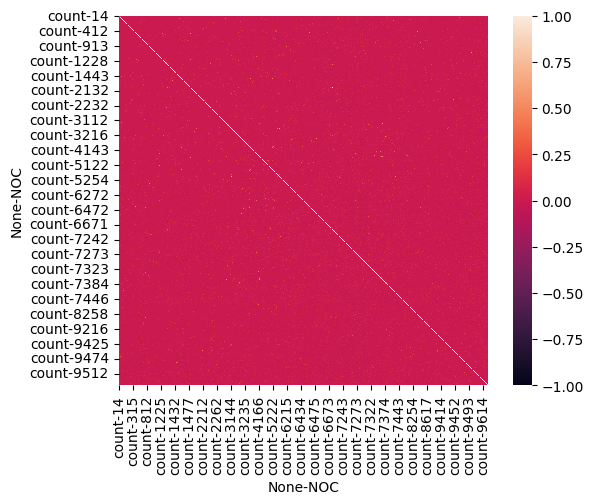

In [6]:
one_hot(NOC, ['count'], ['NOC'])

In [7]:
accidents

,date,worker_age,occupation_category_code,occupation_category_description,NOC,occupation_description,worker_experience_in_years,accident_source_category_description1,source_category_description2,accident_category_description,accident_place_description,city,organization_province_code,industry_sector_description
0,2023-10-14,58.0,72,FACILITY OPERATION AND MAINTENANCE MANAGERS,722.0,facility operation managers,0.5,FLOORS,UNKNOWN,FALL ON SAME LEVEL,PLACE NOT SPECIFIED,markham,ON,transportation
1,2023-11-04,29.0,732,MOTOR VEHICLE MECHANICS,7322.0,"motor vehicle mechanics, technicians and mecha...",0.5,TRUCK,"VEHICLE & MOBILE EQUIP. PARTS, N.E.C.",CAUGHT IN OR COMPRESSED BY EQUIP./OBJECTS,FARM.,winnipeg,MB,industrial
2,2023-12-17,30.0,745,LONGSHORE WORKERS AND MATERIAL HANDLERS,7453.0,material handlers,0.5,"PLANT & INDUSTRIAL POWERED VEHICLE, N.E.C.","BODILY MOTION OR POSITION OF INJURED, ILL WORKER",STRUCK BY OBJECT,"RESIDENTIAL INSTITUTION. (HOSPITALS, ORPHANAGE...",harriston,ON,industrial
3,2023-11-13,64.0,961,"LABOURERS IN PROCESSING, MANUFACTURING AND UTI...",9613.0,labourers in metal fabrication,0.5,PARKING LOTS,WEATHER AND ATMOSPHERIC CONDITIONS,FALL ON SAME LEVEL,PLACE FOR SPORTS AND RECREATION.,markham,ON,manufacturing
4,2023-11-13,74.0,741,MOTOR VEHICLE AND TRANSIT DRIVERS,7412.0,truck drivers,0.5,OTHER STRUCTURES,WEATHER AND ATMOSPHERIC CONDITIONS,FALL ON SAME LEVEL,PUBLIC BUILDINGS.,newcastle,ON,industrial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15426,2022-11-25,51.0,961,"LABOURERS IN PROCESSING, MANUFACTURING AND UTI...",9619.0,"other labourers in processing, manufacturing a...",0.5,"STAIRS, STEPS","BODILY MOTION OR POSITION OF INJURED, ILL WORKER",FALL TO LOWER LEVEL,HOME.,toronto,ON,construction
15427,2023-07-24,57.0,761,TRADES HELPERS AND LABOURERS,7612.0,construction trades helpers and labourers,0.5,TRACTOR,UNKNOWN,"PEDESTRIAN STRUCK BY VEHICLE, MOBILE EQUIPMENT",INDUSTRIAL SITE.,dunchurch,ON,construction
15428,2023-07-05,60.0,735,STATIONARY ENGINEERS & POWER STATION & SYSTEM...,7353.0,power systems and power station operators,0.5,"BODILY MOTION OR POSITION OF INJURED, ILL WORKER","BODILY MOTION OR POSITION OF INJURED, ILL WORKER",REPETITIVE MOTION,INDUSTRIAL SITE.,ajax,ON,manufacturing
15429,2022-05-05,42.0,341,ASSISTING OCCUPATIONS IN SUPPORT OF HEALTH SER...,3414.0,nurse aides and orderlies,0.5,HEALTH CARE PATIENT OR RESIDENT OF HEALTH CARE...,UNKNOWN,"ASSAULTS, VIOLENT ACTS AND HARASSMENT BY PERSO...",PLACE NOT SPECIFIED,toronto,ON,health_care


In [8]:
age_sector = accidents[['date', 'worker_age', 'industry_sector_description']]
age_sector['count'] = 1
age_sector = age_sector.groupby(['date', 'worker_age', 'industry_sector_description']).sum().reset_index()

sector_source = accidents[['date', 'industry_sector_description', 'accident_source_category_description1']]
sector_source['count'] = 1
sector_source = sector_source.groupby(['date', 'industry_sector_description', 'accident_source_category_description1']).sum().reset_index()
# sector_source['source_sector'] = sector_source['industry_sector_description']+' - '+sector_source['accident_source_category_description1']
# sector_source = sector_source[['date', 'source_sector', 'count']]

exp_sector = accidents[['date', 'worker_experience_in_years', 'industry_sector_description']]
exp_sector['count'] = 1
exp_sector = exp_sector.groupby(['date', 'worker_experience_in_years', 'industry_sector_description']).sum().reset_index()

# one_hot(age_sector, ['worker_age', 'count'], ['industry_sector_description'], False)
age_sector['age_range'] = 'unknown'
age_sector['age_range'][age_sector['worker_age']<6] = '1 to 5'
age_sector['age_range'][(age_sector['worker_age']<20) & (age_sector['worker_age']>5)] = '6 to 19'
age_sector['age_range'][(age_sector['worker_age']<50) & (age_sector['worker_age']>19)] = '20 to 49'
age_sector['age_range'][age_sector['worker_age']>49] = '50 or more'
temp = age_sector.drop(columns=['worker_age'])

exp_sector['exp_range'] = 'unknown'
exp_sector['exp_range'][exp_sector['worker_experience_in_years']<6] = '1 to 5'
exp_sector['exp_range'][(exp_sector['worker_experience_in_years']<20) & (exp_sector['worker_experience_in_years']>5)] = '6 to 19'
exp_sector['exp_range'][(exp_sector['worker_experience_in_years']<50) & (exp_sector['worker_experience_in_years']>19)] = '20 to 49'
exp_sector['exp_range'][exp_sector['worker_experience_in_years']>49] = '50 or more'
temp = exp_sector.drop(columns=['worker_experience_in_years'])

exp_occ = accidents[['date', 'worker_experience_in_years', 'occupation_description']]
exp_occ['count'] = 1
exp_occ = exp_occ.groupby(['date', 'worker_experience_in_years', 'occupation_description']).sum().reset_index()
exp_occ['exp_range'] = 'unknown'
exp_occ['exp_range'][exp_occ['worker_experience_in_years']<6] = '1 to 5'
exp_occ['exp_range'][(exp_occ['worker_experience_in_years']<20) & (exp_occ['worker_experience_in_years']>5)] = '6 to 19'
exp_occ['exp_range'][(exp_occ['worker_experience_in_years']<50) & (exp_occ['worker_experience_in_years']>19)] = '20 to 49'
exp_occ['exp_range'][exp_occ['worker_experience_in_years']>49] = '50 or more'
temp = exp_occ.drop(columns=['worker_experience_in_years'])

/var/folders/wn/wdlhry7x1m75kh1md7t0x5p00000gn/T/ipykernel_54625/3132168667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_sector['count'] = 1
/var/folders/wn/wdlhry7x1m75kh1md7t0x5p00000gn/T/ipykernel_54625/3132168667.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sector_source['count'] = 1
/var/folders/wn/wdlhry7x1m75kh1md7t0x5p00000gn/T/ipykernel_54625/3132168667.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [9]:
temp

,date,occupation_description,count,exp_range
0,2020-12-28,"motor vehicle assemblers, inspectors and testers",1,6 to 19
1,2020-12-29,other professional occupations in social science,1,1 to 5
2,2020-12-29,roofers and shinglers,1,1 to 5
3,2020-12-29,"contractors and supervisors, other constructio...",1,1 to 5
4,2020-12-29,lumber graders and other wood processing inspe...,1,6 to 19
...,...,...,...,...
14457,2024-12-28,delivery drivers,1,1 to 5
14458,2024-12-28,"labourers in food, beverage and tobacco proces...",1,1 to 5
14459,2024-12-29,"customer service, information and related clerks",1,1 to 5
14460,2024-12-29,"janitors, caretakers and building superintendents",1,1 to 5


/var/folders/wn/wdlhry7x1m75kh1md7t0x5p00000gn/T/ipykernel_54625/1735211666.py:14: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  final = pd.merge(final, df, on='date')
/var/folders/wn/wdlhry7x1m75kh1md7t0x5p00000gn/T/ipykernel_54625/1735211666.py:16: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  final = final.drop(columns=['date'])


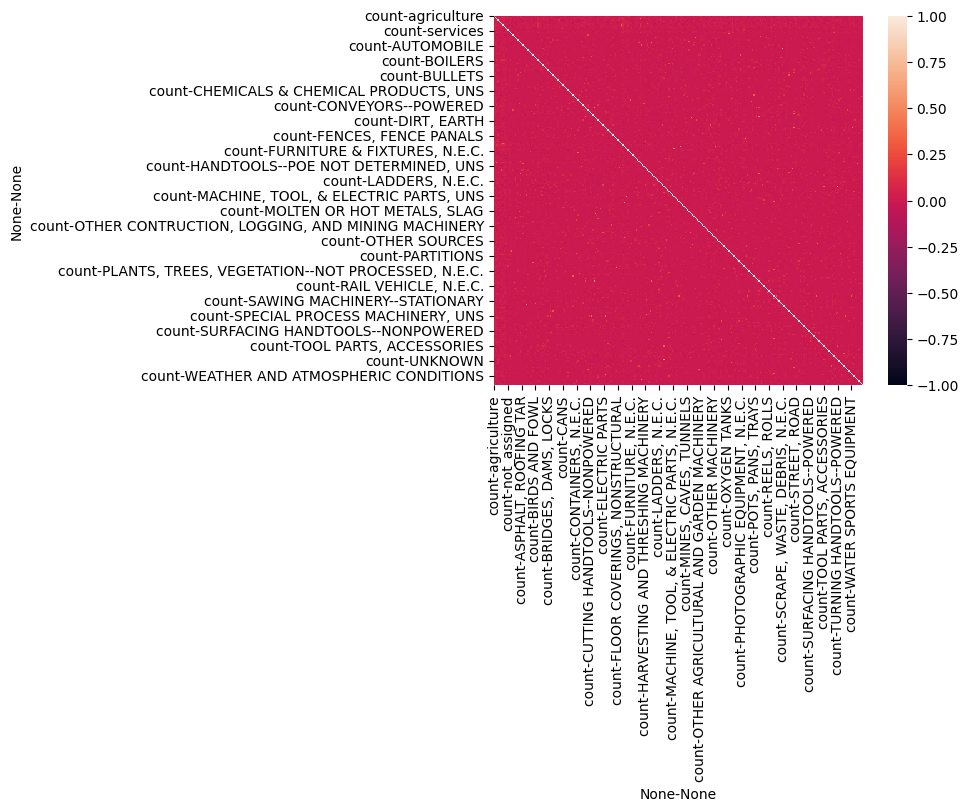

In [10]:
cor(sector_source, ['count'], ['industry_sector_description', 'accident_source_category_description1'], False)
# cor(temp, ['count'], ['exp_range', 'occupation_description'], False)

In [11]:
# print(co.columns)

### Interactive Plot

In [12]:
data = accidents.copy()

columns = data.columns.tolist()

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Interactive One-Hot Heat Map Viewer"),

    html.Div([
        html.Label("Select Value Column (for one-hot encoding):"),
        dcc.Dropdown(id='value-selector', options=[{'label': col, 'value': col} for col in columns], value=columns[-1]),

        html.Label("Select Category Columns (for one-hot encoding):"),
        dcc.Dropdown(id='category-selector', options=[{'label': col, 'value': col} for col in columns], value=[columns[1]], multi=True),

        html.Label("Enable Pivot (c argument):"),
        dcc.Checklist(id='pivot-check', options=[{'label': 'Enable', 'value': 'enabled'}], value=['enabled']),
        
        html.Button("Save Plot", id='save-button', n_clicks=0),

        html.Label("Adjust Figure Size:"),
        dcc.Input(id='fig-width', type='number', value=10, step=1, min=5, max=20, placeholder='Width'),
        dcc.Input(id='fig-height', type='number', value=8, step=1, min=5, max=20, placeholder='Height'),
    ], style={'width': '48%', 'display': 'inline-block'}),

    html.Img(id='heatmap-image')
])

@app.callback(
    Output('heatmap-image', 'src'),
    [Input('value-selector', 'value'),
     Input('category-selector', 'value'),
     Input('pivot-check', 'value'),
     Input('fig-width', 'value'),
     Input('fig-height', 'value'),
     Input('save-button', 'n_clicks')]
)
def update_heatmap(category_col, value_cols, annot_enabled, fig_width, fig_height, n_clicks):
    if category_col:
        # Apply one-hot encoding with selected parameters
        a_enabled = 'enabled' in annot_enabled
        
        data = accidents[['date'] + value_cols + [category_col]]
        data['count'] = 1
        if value_cols == []:
            data = data.groupby(['date'] + [category_col]).sum().reset_index()
        else:
            try:
                data[value_cols] = data[value_cols].astype(float)
            except:
                raise Exception("The second filter should be numberic!")
            # print(data)
            # data[value_cols] = data[value_cols].fillna('Unknown')
            # data = data.groupby(['date', 'city', 'accident_place_description']).sum().reset_index()
            data = data.groupby(['date'] + value_cols + [category_col]).sum(numeric_only=True).reset_index()
        
        plt.figure(figsize=(fig_width, fig_height))
        one_hot(data, value_cols + ['count'], [category_col], a_enabled)
        plt.tight_layout()

        buf = BytesIO()
        plt.savefig(buf, format="png")
        buf.seek(0)
        encoded_image = base64.b64encode(buf.read()).decode('utf-8')
        buf.close()

        if n_clicks > 0:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_path = f"report/dataset2/heatmap_plot_{timestamp}.png"
            plt.savefig(save_path)
            print("Figure saved in", save_path)

        plt.close()
        return f"data:image/png;base64,{encoded_image}"

    else:
        return "data:image/png;base64,"

if __name__ == '__main__':
    app.run_server(debug=True)


/var/folders/wn/wdlhry7x1m75kh1md7t0x5p00000gn/T/ipykernel_54625/2855972444.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/wn/wdlhry7x1m75kh1md7t0x5p00000gn/T/ipykernel_54625/2855972444.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/wn/wdlhry7x1m75kh1md7t0x5p00000gn/T/ipykernel_54625/2855972444.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th